# Assignment 7: t-SNE for Dimensionality Reduction and Visualization

## 1. PCA vs t-SNE

Previously we looked at PCA as a method for dimensionality reduction by transforming data using a basis of the direction of maximum variation. Here we'll compare the two methods using the out of the box methods from scikit-learn. Make sure to fill in all TODOs!

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Some Setup

In [3]:
from sklearn.datasets import load_digits
from sklearn.utils import shuffle
#we are using the MNIST dataset
digits = load_digits()

In [4]:
X = digits.data
y = digits.target

In [5]:
# Scale X to be between 0 and 1 (avoid magic numbers - define global constants and use them!)

# TODO: Scale X to be between 0 and 1 (subtract minimum, divide by distance between minimum and maxium)
R = np.max(X)-np.min(X)
X = (X-np.min(X))/R
print(np.shape(X),np.max(X),np.min(X),np.std(X),np.mean(X))


(1797, 64) 1.0 0.0 0.3760492217920148 0.30526028624095713


In [6]:
# Shuffle data

X, y = shuffle(X, y)

In [7]:
#Dataset consists of 1797 images, each of which has 64 pixels
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1797, 64)
y shape: (1797,)


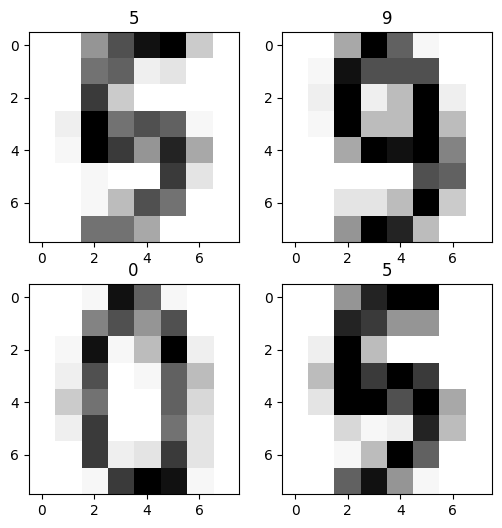

In [8]:
# Look at the data we're working with

plt.figure(figsize=(6,6))

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(y[i])
    #TODO: Plot X[i]
    #Hint: Use plt.imshow, reshape the image to be 8x8
    #You can set cmap to 'Greys' to have the image be in grayscale
    im = np.reshape(X[i],[8,8])
    plt.imshow(im,cmap='Greys')

plt.show()

As you can see from the above code, our input data has 64 features, each resembling a pixel in each image. We want to reduce the dimensionality of our input using both PCA and t-SNE to visualize all the data points on one chart.

### 1.a) PCA

In [9]:
# Carry out PCA on X

pca = PCA(n_components=2)
# TODO: Run PCA on X to get the first 2 principal components
pca.fit(X)

X_pca = pca.transform(X)
print(np.shape(X_pca))

(1797, 2)


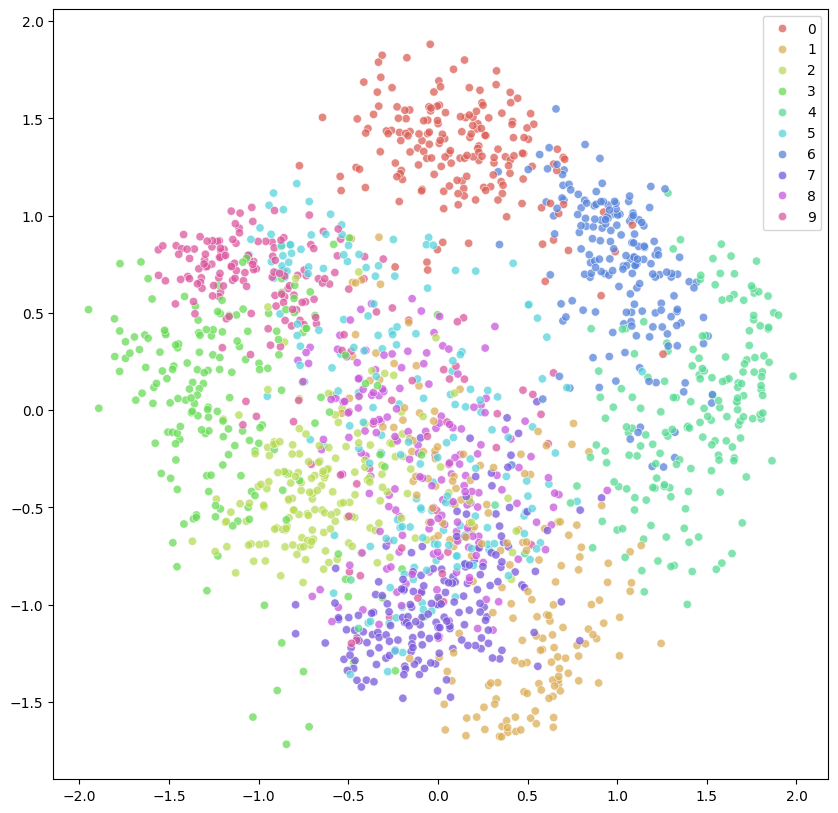

In [10]:
# Visualize X_pca

plt.figure(figsize=(10,10))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=y,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75)

plt.show()

### 1.b) t-SNE

In [11]:
# Carry out t-SNE on X

tsne = TSNE(n_components=2)
# TODO: Run t-SNE on X
X_tsne = tsne.fit_transform(X)
print(np.shape(X_tsne))


(1797, 2)


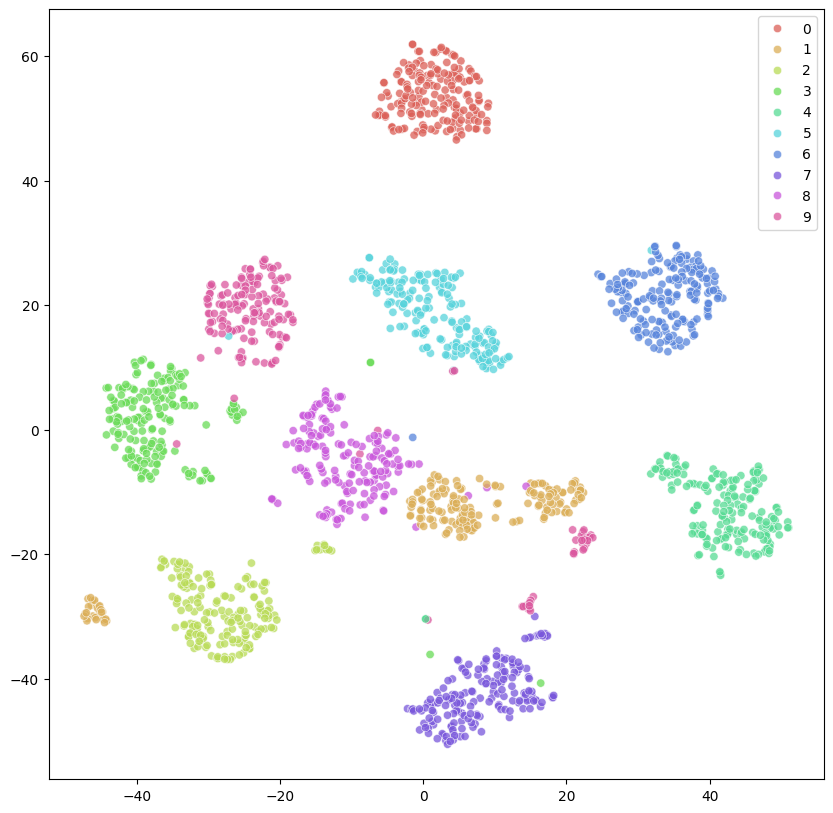

In [12]:
# Visualize X_tsne

plt.figure(figsize=(10,10))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=y,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75
)
plt.show()

## 2. Implementing t-SNE

In this exercise, we will follow the implementation of t-SNE directly from the 2008 paper by Maaten and Hinton. It builds upon SNE (Stochastic Neighbor Embedding) and "reduces the tendency to crowd points together in the center
of the map." You can find the paper on bcourses - read through the paper before you start (sections 2 and 3.3 are particularly relevant).

#### Intro/Definitions

The goal of t-SNE is to define a location $y_i$ in low-dimension space for high-dimensional points $x_i$. Each point $x_i$ has a probability distribution associated with it of picking another point $x_j$ as its neighbor, defined as $p_{j|i}$ in equation 1 of the paper. $P_i$ is defined as the probability distribution (of choosing that datapoint as the neighbor of $x_i$) across all other high-dimensional points given $x_i$. Note that  Analagously for the low-dimensional points (which we have yet to find), $Q_i$ is defined as the distribution of other low-dimensional points given $y_i$

#### Cost function description

In SNE, the cost function that we're trying to minimize is the "difference" between $P_i$ and $Q_i$ (we want them to be similar). How do we measure difference for probability distributions? The Kullback-Leibler divergence is a measure of dissimilarity between two distributions $P$ and $Q$, defined as $$ \sum_i \left( P(i) \cdot log \frac{P(i)}{Q(i)} \right) $$ for all values $i$ that $P$ and $Q$ take on. You can see how if $P = Q$ for all $i$ (same distribution), the log term will always be $\log 1 = 0$, and so the KLD will be 0 (no dissimilarity).

As they state in the paper, "In particular, there
is a large cost for using widely separated map points to represent nearby datapoints (i.e., for using a small $q_{j|i}$ to model a large $p_{j|i}$), but there is only a small cost for using nearby map points to
represent widely separated datapoints." You can see that is true - if for some pair of points the $q$ is big and the $p$ is not, the term $$p\cdot log \frac{p}{q}$$ will be small! That will mean that it can mistranslate to low dimension sneakily without seeming like the cost is going up. That is one of the motivations behind t-SNE over SNE.

In [32]:
#NOTE: for all the TODOs in this exercise, use numpy functions
#do NOT use for loops - they will be way too slow to run tSNE

def find_H_and_P_i(D=np.array([]), beta=1.0):
    """
    Compute the entropy (directly connected to the perplexity) and the P-row for a specific
    datapoint x_i, given squared euclidean distances between x_i and every other point,
    as well as beta (the precision of the Gaussian distribution around X_i).

    As we see in the paper, the perplexity can be interpreted as a smooth measure of the
    effective number of neighbors (non-integer). The entropy H is connected
    to the perplexity through Perplexity =2**H.

    Inputs:
    - D is a vector representing the squared distance of each point x_j to x_i
    - beta is 1/(2*sigma^2) - a measure of the precision of the Gaussian distribution around X_i

    Outputs:
    - H is the entropy (which we will use as a measure of the perplexity)
    - P_i (a vector) is the probability density representing the similarity of x_i and each neighbor x_j
    """
    # TASK: Follow equation 1 and compute the numerators of all the p_j|i.

    # TODO: Assuming beta represents whatever variance division
    # term the algorithm decides, multiply and exponentiate to get P's
    # numerator. Check your signs!
    # Hint: No subtraction is necessary because x_i's position is
    # treated as 0, since we are looking at the Gaussian around x_i.

    P_i = np.exp(-beta*D) #numerator from second equation in eq 3 in paper

    # computing perplexity in a vectorized + fast manner
    # it's most efficient to just find the entropy
    # https://stats.stackexchange.com/a/399328/223727
    H = np.log2(np.sum(P_i)) + beta * np.sum(D * P_i) / np.sum(P_i)
    # entropy is directly related to perplexity through Perplexity = 2**H

    # TODO: Normalize P_i to apply conditioning (1 line)
    P_i = P_i / np.sum(P_i)

    return H, P_i

Now we will use the perplexity (entropy) and conditional probability distributions we have computed, and brute force search for conditional Gaussians that have the same perplexity! (i.e. the $P_i$'s, or the rows of the $n$ by $n$ $P$ matrix)

A way to intuitively think about this is that we should expect any two points to estimate that the "soft" number of neighbors is the same, if they're in the same neighborhood.

In [33]:
def find_P_from_X(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
    Performs a binary search to find the values of beta
    such that each conditional Gaussian has the same desired perplexity.

    Computes the values of P given these values of beta
    and returns P.

    Inputs:
    - X - an n by d matrix of the data, where n is the number of samples
        and d is the number of features
    - tol - the tolerance for H. Stop if H is within tol of the log of
        the desired perplexity
    - perplexity - the desired perplexity. Intuitively, a guess about the
        number of close neighbors each datapoint has

    return:
    - P - a matrix where each row is the probability density that
        represents how likely x_i is to choose each other datapoint x_j
        as its neighbor
    """
    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    #D_ij is the squared distance from x_i to x_j
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)

    # NOTE: the P you compute should be of this shape.
    # Make sure you understand why!
    P = np.zeros((n, n))
    beta = np.ones((n, 1))

    # NOTE: the log of the perplexity is our target entropy
    logU = np.log2(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        # np.r_ just efficiently concatenates along the row
        # https://stackoverflow.com/a/30597960/10302846
        D_i = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]

        # TODO: Utilize your newly written function to get perplexity and Pvals
        # (1 line)
        H, P_i = find_H_and_P_i(D_i)

        # TODO: Evaluate whether the perplexity is within tolerance - use logU (1 line)
        H_diff = H - logU
        # Hint - don't apply absolute value yet - we need to know the sign
        # of this value for binary search! You can apply abs in the loop cond.

        tries = 0

        # TODO:
        # Write a loop condition that continues if we're both below the max
        # number of tries (50), and the absolute difference is greater than
        # the tolerance.

        while tries<50 and abs(H_diff)>tol :

            # TASK: If not, increase or decrease the precision (beta)
            # What follows here is a version of the standard binary search checks.
            # The idea is that if we're too high (H_diff positive), we can set the
            # new min to be our current beta, and move our beta towards the max.
            # If the max is currently infinity, we should just double beta.
            # If the max is an actual number, set beta to be the avg of it and max.

            if H_diff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    # adjust the beta
                    # TODO:
                    beta[i] = beta[i]*2
                else:
                    # adjust the beta
                    # TODO:
                    beta[i] = 0.5*(beta[i]+betamax)
            else:
                # Opposite of above (if H_diff is negative)
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    # TODO:
                    beta[i] = beta[i]/2
                else:
                    # TODO:
                    beta[i] = 0.5*(beta[i]+betamin)

            # TODO: Recompute the values again using your function and the new betas
            H, thisP = find_H_and_P_i(D_i,beta[i])

            # TODO: Recompute H_diff
            # (same as "Evaluate whether the perplexity is within tolerance")
            H_diff = H - logU

            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = P_i

    # Return final P-matrix
    print(P[1])
    print("Mean value of sigma: %f" % np.mean(np.sqrt(0.5 / beta)))
    return P

In [15]:
def pca(X=np.array([]), n_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        n_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:n_dims])
    return Y

Now, we will use the Student t-distribution with one degree of freedom to compute $Q$, the matrix of joint probabiltiies in low dimensions (see equation 4 of the paper).

When calculating the numerator of $Q$ note that $ \lVert y_i - y_j \rVert^2 $ can be expanded as $y_i^{T} y_i - 2y_i^T y_j + y_j^T y_j$.

In [42]:
def tsne(X=np.array([]), n_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to n_dims dimensions.

        Uses PCA to reduce X to initial_dims dimensions, first.
    """

    # Check inputs
    if isinstance(n_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(n_dims) != n_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 400
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, n_dims)
    dY = np.zeros((n, n_dims))
    iY = np.zeros((n, n_dims))
    gains = np.ones((n, n_dims))
    tolerance = 1e-5

    #TODO:
    # Compute P-values using your previous function
    # remember to pass tolerance and perplexity to the function
    P = find_P_from_X(X,tolerance,perplexity)

    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4 # early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # TASK: Compute pairwise affinities (Q)

        # SUBTASK: compute the numerator `num`


        #TODO: first, find the norm squared

        #Hints:
        #look at the expansion of norm squared in the above cell
        #To find the matrix of norm squared, you can
        #  find a matrix for each term and sum them together
        #For the first and third terms, you will need to use np.square and np.sum
        #  consider the orientation of Y - is y_i a row or a column?
        #for the middle (-2) term, you will need to compute the outer product
        #  of Y with itself (use np.dot)
        #remember - do NOT use for loops - they will be too slow
        sum_y = np.sum(np.square(Y), 1)
        norm_sq = np.add(np.add(-2 * np.dot(Y, Y.T), sum_y).T, sum_y) #this is a matrix where norm_sq[i][j] = ||y_i - y_j||^2
        # ^ last hint: we already had to find squared distances elsewhere in the code, for ||x_i - x_j||^2

        #TODO: next, find the numerator using norm_sq - look at equation 4 in pdf
        num = np.divide(1,(norm_sq+1))
        # END OF SUBTASK

        # TODO: set the diagonal of numerator to 0 (because q_ii = 0), and normalize it to get Q
        # you can index into matrix using [range(a), range(a)] to get the diagonal elements
        # (2 lines)
        num[range(len(num)),range(len(num))] = 0
        # Q = (num.T/num.sum(axis=1)).T
        Q = num / np.sum(num)

        # END OF TASK

        # this makes Q nonzero/non-negative, because floats are terrible
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (n_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            # TODO: Implement KL Divergence cost function on P and Q

            C = np.sum(np.multiply(P,(np.log(P)-np.log(Q))))
            # HINT: make sure you wrap it with an np.sum so it's a scalar

            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop exaggerating about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P for point 0 of 1797...
Computing P for point 500 of 1797...
Computing P for point 1000 of 1797...
Computing P for point 1500 of 1797...
[8.13155618e-04 0.00000000e+00 1.16505322e-03 ... 5.11898539e-05
 2.67675450e-02 6.35463877e-05]
Mean value of sigma: 0.635065
Iteration 10: error is 15.578958
Iteration 20: error is 13.531251
Iteration 30: error is 11.758883
Iteration 40: error is 11.702469
Iteration 50: error is 11.848406
Iteration 60: error is 11.959091
Iteration 70: error is 11.952776
Iteration 80: error is 11.949748
Iteration 90: error is 11.946501
Iteration 100: error is 11.945987
Iteration 110: error is 1.099662
Iteration 120: error is 0.790271
Iteration 130: error is 0.680971
Iteration 140: error is 0.626619
Iteration 150: error is 0.593027
Iteration 160: error is 0.570588
Iteration 170: error is 0.554869
Iteration 180: error is 0.543438
Iteration 190: error is 0.534917
Iteration 200: error is 0.528

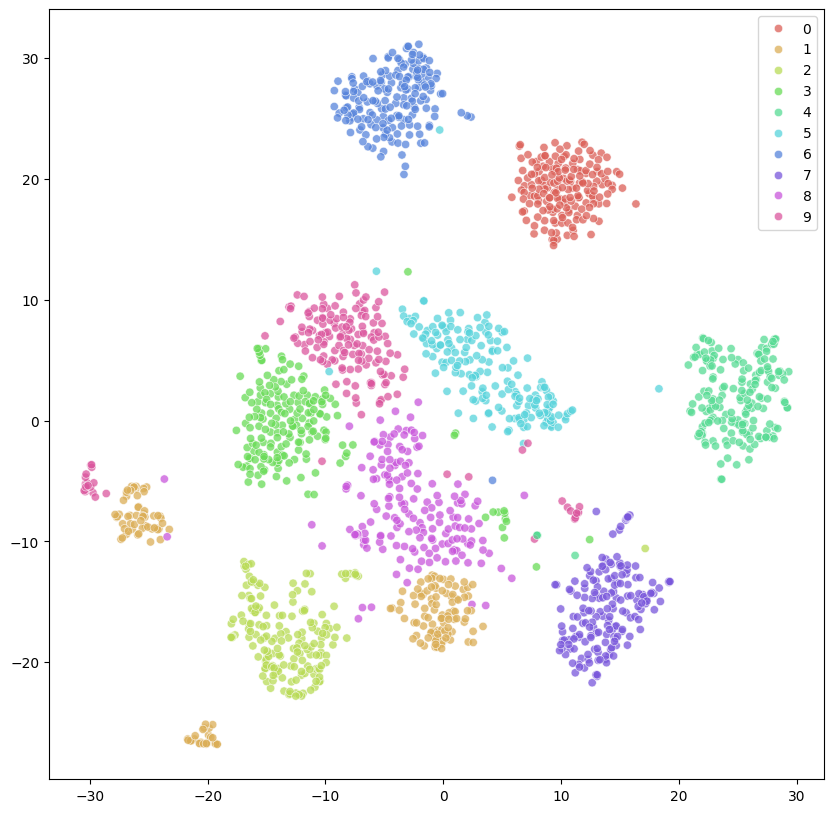

In [43]:
# Run TSNE again to check that the implementation's output matches the library version's output!
X_tsne = tsne(X)

plt.figure(figsize=(10,10))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=y,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75
)
plt.show()

If your implementation is correct, you should see good separation much like the run in Question 1, though the shapes and locations of the clusters likely won't be the same (due to our implementation and parameters differing slightly from the sklearn t-SNE).

## 3. Conceptual Questions

### 3.a) To optimize the performance of the method, we scaled P by 4 for the first 100 iterations of gradient descent. How does this improve performance?

see: Section 3.4 in the paper

TODO:

Multiplying the p\_ij in the initial stages of the optimization process will force the model to focus on large pij by finding large qij. This finds the large structures within the data relatively quickly.

### 3.b) In the above implementation, we used PCA to first reduce the input to 50 dimensions/features - why is it preferred to run t-SNE on data that doesn't have a high number of dimensions?

see: Section 6.2, number 2 in the paper

TODO:

t-SNE is sensitive to the intrinisic dimensionality of the data, therefore, with high dimensional data, with large variability in the local manifolds, the assumptions of t-SNE might be violated and this results in mappings that are not valid. It, is, therefore, common for PCA or other linear dimensionality reductions to be used before t-SNE is applied.

### 3.c) t-SNE is known to be a 'nonlinear' dimensionality reduction method. As such the distance between points does not accurately reflect distance in the original space. Based on the math behind the technique, explain why t-SNE is nonlinear.

see: Section 2 in the paper

TODO:

t-SNE is non-linear because we are computing distributions using the square distance between the points and then normalizing this probability by the sum of all probabilities. The process of finding the Q distribution is also non-linear because we investigate the KL divergence between the two distributions and this means that the distance between two points y\_1 and y\_2 in the mapped space is not linearly dependent on the distance between these two points in the original space x\_1 and x\_2.

### 3.d) Explain the improvement of this method over SNE - specifically, why is the distance between two points in the lower-dimensional space defined as (1) rather than the definition of distance used for the higher dimensional space (2), ignoring the symmetrization?


$$q_{i j} = \frac{(1+||y_i - y_j||^2)^{-1}}{\sum_{k \neq l}(1+||y_k - y_l||^2)^{-1}} \;\;\;\;\;\;  (1)$$

$$p_{i j} = \frac{\text{exp}(-||x_i - x_j||^2 / 2\sigma^2)}{\sum_{k \neq l}\text{exp}(-||x_k - x_l||^2/ 2\sigma^2)} \;\;\;\;\;\;  (2)$$

see: Section 3 in the paper

TODO:
Using the t-distribution rather than the Gaussian distribution in the mapped space solves two common problems with SNE: 1) the heavy-tail distribution used in t-SNE solves the crowding problem 2) the symmetric cost function and distribution used make the gradient computation and optimization of the cost function easier.